# Prepare text files for each entry
- reference
- Pero OCR
- Tesseract OCR

In [1]:
import os.path

In [2]:
DATASET_PATH = os.path.abspath("../../dataset/supervised")
DATASET_PATH

'/home/joseph/git_github/soduco/paper-ner-bench-das22/dataset/supervised'

In [3]:
ref_path = os.path.join(DATASET_PATH, "10-ref-ocr-ner-json", "all.json")
pero_path = os.path.join(DATASET_PATH, "21-ocr-pero-final", "all.json")
tess_path = os.path.join(DATASET_PATH, "22-ocr-tess-final", "all.json")

## Text file generation

In [4]:
import json
import io

In [5]:
def generate_text_files(json_path, output_dir):
    entries = None
    with open(json_path) as in_file:
        entries = json.load(in_file)
    for entry in entries:
        out_filename = f'{entry["book"]}-{entry["page"]:04d}-{entry["id"]:04d}.txt'
        out_path = os.path.join(output_dir, out_filename)
        text = entry["text_ocr"]
        with io.open(out_path, "wt", encoding="UTF-8", newline='', errors="strict") as file_output:
            file_output.write(text)


In [ ]:
for (in_, out) in [(ref_path, "ref"), (pero_path, "pero"), (tess_path, "tess")]:
    out_dir = os.path.join(DATASET_PATH, "80-ocr-text-files", out)
    print(out)
    generate_text_files(in_, out_dir)

## Generate report OCR report

In [7]:
import OCRMetrics
import pandas as pd
import json

with open(ref_path) as f:
    reference = json.load(f)
with open(pero_path) as f:
    pero = json.load(f)
with open(tess_path) as f:
    tess = json.load(f)

uid = lambda x: (x["book"], x["page"], x["id"]) 
ref = { uid(x) : x["text_ocr"] for x in reference }
boxes = { uid(x) : tuple(int(r) for r in x["box"]) for x in reference }
pero = { uid(x) : x["text_ocr"] for x in pero }
tess = { uid(x) : x["text_ocr"] for x in tess }
all_keys = set(ref.keys()) & set(pero.keys()) & set(tess.keys())
valid_keys = set(uid(x) for x in reference if x["valid_box"])

pero_scores = { k : OCRMetrics.align(ref[k], pero[k]) for k in all_keys }
tess_scores = { k : OCRMetrics.align(ref[k], tess[k]) for k in all_keys }

def make_df(scores, index):
    stats = { k : r.stats for k,r in scores.items() }
    data = [ (k[0], k[1], k[2], s.errors, s.reference_length, s.length, index[k]) for k, s in stats.items() ]
    df = pd.DataFrame.from_records(data, columns=["Book", "Page", "Id", "Errors", "RefLength", "Length", "TextPred"] )
    df = df.set_index(["Book", "Page", "Id"])
    return df

pero_df = make_df(pero_scores, pero)
tess_df = make_df(tess_scores, tess)
#all_df = pd.merge(pero_df, tess_df, suffixes=["_pero", "_tess"], how="inner", on=["Book", "Page", "Id"])



Note that dict keys are set-like objects.

In [8]:
# pero.keys?

In [9]:
# Pero and Tess must have the same entries
assert(len(pero.keys() ^ tess.keys()) == 0)

In [10]:
# Pero and Tess must have only valid boxes
assert(pero.keys() == valid_keys)
assert(tess.keys() == valid_keys)

In [11]:
# Pero and Tess must be included in Ref
assert(pero.keys() <= ref.keys())
assert(tess.keys() <= ref.keys())

In [12]:
# Check for duplicate ids
# -> Should be done before

(0.01, 1.0)

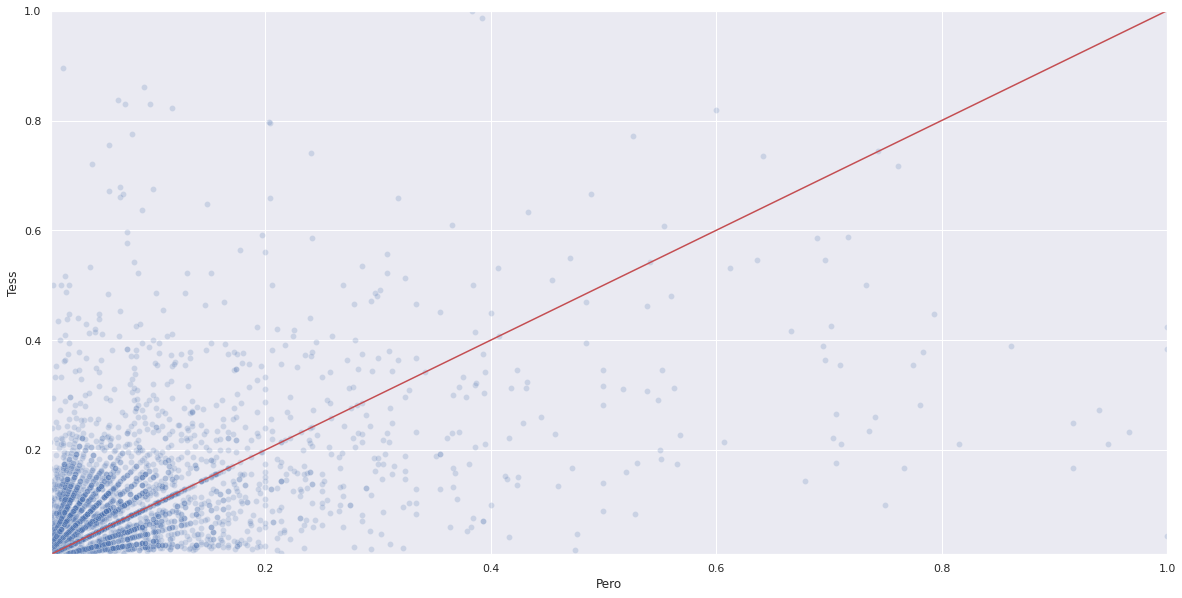

In [13]:
import seaborn as sns
import matplotlib.lines as lines
import matplotlib.pyplot as plt
sns.set_theme()

CER_pero = pero_df["Errors"] / pero_df["RefLength"]
CERnorm_pero = pero_df["Errors"] / pero_df["Length"]
CER_tess = tess_df["Errors"] / tess_df["RefLength"]
CERnorm_tess = tess_df["Errors"] / tess_df["Length"]


uniq_df = pd.DataFrame( data = [ (k[0], k[1], k[2], ref[k], boxes[k]) for k in all_keys ], columns=["Book", "Page", "Id", "TextRef", "Boxes"])
uniq_df = uniq_df.set_index(["Book", "Page", "Id"])

errors = pd.DataFrame( { "Pero": CER_pero, "Tess" : CER_tess , "PeroPred" : pero_df["TextPred"], "TessPred" : tess_df["TextPred"]})
errors = pd.concat([errors, uniq_df], axis=1, join='inner')  

fig, ax = plt.subplots(figsize=(20,10))
fig = sns.scatterplot(data = errors, x = "Pero", y = "Tess", ax=ax, alpha=0.2)
fig.add_artist(lines.Line2D([0, 1], [0, 1], color='r'))
#fig.set_xscale("log")
#fig.set_yscale("log")
fig.set_xlim(0.01, 1)
fig.set_ylim(0.01, 1)

#errors

<AxesSubplot:>

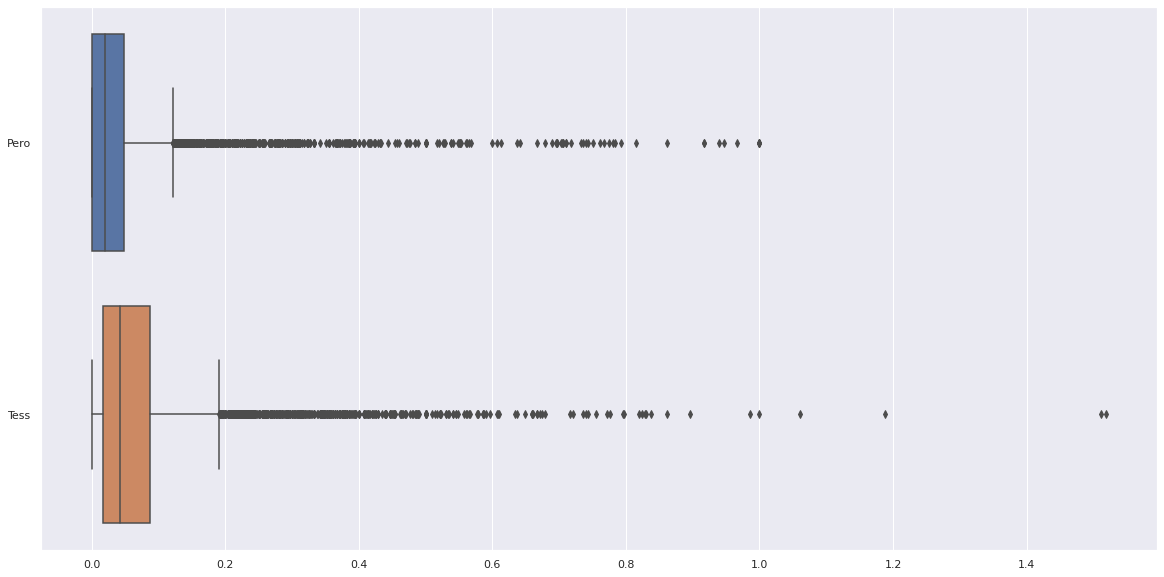

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data=errors, orient='h', ax=ax)

In [15]:
byerr = errors.sort_values(by=["Pero"])
byerr[(byerr["Pero"] >= 0.9) | (byerr["Tess"] >= 0.9)]
is_valid = lambda b: b[2] > 50
valid = errors["Boxes"].apply(is_valid)
pd.options.display.float_format = '{:,.2f}'.format
errors[~valid]

,,,Pero,Tess,PeroPred,TessPred,TextRef,Boxes
Book,Page,Id,,,,,,


In [16]:
# errors.loc["Bottin1_1827",117,:].sort_index().loc[520:]

In [17]:
pero_cer = pero_df["Errors"].sum() / pero_df["RefLength"].sum()
tess_cer = tess_df["Errors"].sum() / tess_df["RefLength"].sum()

print("Pero CER: {:.2f}%".format(100 * pero_cer))
print("Tess CER: {:.2f}%".format(100 * tess_cer))
print("Pero Accuracy: {:.2f}%".format(100 * (1 - pero_cer)))
print("Tess Accuracy: {:.2f}%".format(100 * (1 - tess_cer)))

Pero CER: 3.78%
Tess CER: 6.56%
Pero Accuracy: 96.22%
Tess Accuracy: 93.44%


## With ISRI

In [18]:
import isri_tools

In [19]:
def print_report(report):
    for attr in ("characters", "errors", "false_marks", "reject_characters", "suspect_markers"):
        val = getattr(report, attr)
        print(f"{attr:20s}: {val:10d}")
    accuracy = (report.characters - report.errors) / report.characters
    print(f"{'accuracy':20s}: {accuracy*100:10.2f}%")

In [20]:
pero_report = isri_tools.compute_accurary_summary(
    [ref[k] for k in valid_keys], 
    [pero[k] for k in valid_keys]
    )
print_report(pero_report)
pero_report

characters          :     424764
errors              :      16063
false_marks         :          0
reject_characters   :          0
suspect_markers     :          0
accuracy            :      96.22%


UNLV-ISRI OCR Accuracy Report Version 5.1
-----------------------------------------
  424764   Characters
   16063   Errors
   96.22%  Accuracy

       0   Reject Characters
       0   Suspect Markers
       0   False Marks
    0.00%  Characters Marked
   96.22%  Accuracy After Correction

     Ins    Subst      Del   Errors
       0        0        0        0   Marked
    6225     7615     2223    16063   Unmarked
    6225     7615     2223    16063   Total

   Count   Missed   %Right
   54387     3185    94.14   ASCII Spacing Characters
   57915     3837    93.37   ASCII Special Symbols
   18144     1470    91.90   ASCII Digits
   31971      582    98.18   ASCII Uppercase Letters
  255201     3336    98.69   ASCII Lowercase Letters
      66       41    37.88   Latin1 Special Symbols
      51       44    13.73   Latin1 Uppercase Letters
    6233      912    85.37   Latin1 Lowercase Letters
      25        7    72.00   Latin Extended-A
     383       42    89.03   General Punctuation
 

In [21]:
tess_report = isri_tools.compute_accurary_summary(
    [ref[k] for k in valid_keys], 
    [tess[k] for k in valid_keys]
    )
print_report(tess_report)
tess_report

characters          :     424764
errors              :      27862
false_marks         :          0
reject_characters   :          0
suspect_markers     :          0
accuracy            :      93.44%


UNLV-ISRI OCR Accuracy Report Version 5.1
-----------------------------------------
  424764   Characters
   27862   Errors
   93.44%  Accuracy

       0   Reject Characters
       0   Suspect Markers
       0   False Marks
    0.00%  Characters Marked
   93.44%  Accuracy After Correction

     Ins    Subst      Del   Errors
       0        0        0        0   Marked
    4506    16416     6940    27862   Unmarked
    4506    16416     6940    27862   Total

   Count   Missed   %Right
   54387     1643    96.98   ASCII Spacing Characters
   57915     4750    91.80   ASCII Special Symbols
   18144     2450    86.50   ASCII Digits
   31971     2414    92.45   ASCII Uppercase Letters
  255201     8308    96.74   ASCII Lowercase Letters
      66       26    60.61   Latin1 Special Symbols
      51       26    49.02   Latin1 Uppercase Letters
    6233      873    85.99   Latin1 Lowercase Letters
      25       10    60.00   Latin Extended-A
     383       34    91.12   General Punctuation
 

## Charset study

In [24]:

from text_utils import charset_stats
ref_charset = charset_stats(ref[k] for k in valid_keys)
ref_charset

,repr,ord,name,category,count
0,' ',32,SPACE,Zs,50766
1,'e',101,LATIN SMALL LETTER E,Ll,39418
2,'r',114,LATIN SMALL LETTER R,Ll,25019
3,"','",44,COMMA,Po,24839
4,'a',97,LATIN SMALL LETTER A,Ll,21196
...,...,...,...,...,...
107,'ü',252,LATIN SMALL LETTER U WITH DIAERESIS,Ll,2
108,'Î',206,LATIN CAPITAL LETTER I WITH CIRCUMFLEX,Lu,1
109,'!',33,EXCLAMATION MARK,Po,1
110,'ñ',241,LATIN SMALL LETTER N WITH TILDE,Ll,1


In [25]:
pero_charset = charset_stats(pero[k] for k in valid_keys)
pero_charset

,repr,ord,name,category,count
0,' ',32,SPACE,Zs,48368
1,'e',101,LATIN SMALL LETTER E,Ll,39632
2,'r',114,LATIN SMALL LETTER R,Ll,24894
3,"','",44,COMMA,Po,23818
4,'a',97,LATIN SMALL LETTER A,Ll,21154
...,...,...,...,...,...
125,'и',1080,CYRILLIC SMALL LETTER I,Ll,1
126,'н',1085,CYRILLIC SMALL LETTER EN,Ll,1
127,'т',1090,CYRILLIC SMALL LETTER TE,Ll,1
128,'х',1093,CYRILLIC SMALL LETTER HA,Ll,1


In [26]:
tess_charset = charset_stats(tess[k] for k in valid_keys)
tess_charset

,repr,ord,name,category,count
0,' ',32,SPACE,Zs,52252
1,'e',101,LATIN SMALL LETTER E,Ll,39431
2,"','",44,COMMA,Po,25616
3,'r',114,LATIN SMALL LETTER R,Ll,25245
4,'a',97,LATIN SMALL LETTER A,Ll,21137
...,...,...,...,...,...
125,'Ü',220,LATIN CAPITAL LETTER U WITH DIAERESIS,Lu,2
126,'Î',206,LATIN CAPITAL LETTER I WITH CIRCUMFLEX,Lu,2
127,'Ê',202,LATIN CAPITAL LETTER E WITH CIRCUMFLEX,Lu,2
128,'Œ',338,LATIN CAPITAL LIGATURE OE,Lu,1
